<a href="https://colab.research.google.com/github/wleinemann5/tr-marketplace/blob/main/nfldraft_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch pyro-ppl

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import torch
from pyro.distributions import constraints
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the CSV file
file_path = '/content/drive/My Drive/2024_draft_observations_041324.csv'
data = pd.read_csv(file_path)
#data = pd.read_csv('path_to_your_file.csv')

data['Score'] = data['Score']-.01

In [ ]:
data.head(5)


,Name,Position,Analyst,Score
0,Caleb Williams,QB,Kiper,0.99
1,Marvin Harrison Jr,WR,Kiper,0.97
2,Malik Nabers,WR,Kiper,0.95
3,Jayden Daniels,QB,Kiper,0.98
4,Drake Maye,QB,Kiper,0.93


In [ ]:
# Ensure the score is float and check for any out-of-bound values
data['Score'] = data['Score'].astype(float)
assert data['Score'].between(0, 1).all(), "Scores must be between 0 and 1"

In [ ]:
players = data['Name'].unique()

player_skills = {}
for player in players:
    player_skills[player] = pyro.sample(
        f"{player}_skill",
        dist.Beta(2.0, 40.0)  # weak prior with a mean around 0.05
    )

In [ ]:
player_skills

{'Caleb Williams': tensor(0.1385),
 'Marvin Harrison Jr': tensor(0.0104),
 'Malik Nabers': tensor(0.0317),
 'Jayden Daniels': tensor(0.0179),
 'Drake Maye': tensor(0.0118),
 'Rome Odunze': tensor(0.0766),
 'Joe Alt': tensor(0.0335),
 'Brock Bowers': tensor(0.0620),
 'Dallas Turner': tensor(0.0125),
 'Troy Fautanu': tensor(0.1636),
 'Quinyon Mitchell': tensor(0.0402),
 'Terrion Arnold': tensor(0.0310),
 'Taliese Fuaga': tensor(0.0553),
 'Olu Fashanu': tensor(0.0773),
 'JC Latham': tensor(0.0428),
 'JJ McCarthy': tensor(0.0342),
 'Laiatu Latu': tensor(0.0229),
 'Jared Verse': tensor(0.0684),
 'Brian Thomas': tensor(0.1630),
 'Byron Murphy': tensor(0.0341),
 'Amarius Mims': tensor(0.0782),
 'Graham Barton': tensor(0.0210),
 'Cooper DeJean': tensor(0.0122),
 'Nate Wiggins': tensor(0.0569),
 'Tyler Guyton': tensor(0.0368),
 'Adonai Mitchell': tensor(0.0461),
 'Jerzhan Newton': tensor(0.0388),
 'Chop Robinson': tensor(0.1426),
 'Darius Robinson': tensor(0.0251),
 'Kool-Aid Mckistry': tensor(

In [ ]:
for _, row in data.iterrows():
  print(row['Name'],player_skills[row['Name']] * 99 + 1, (1 - player_skills[row['Name']]) * 99 + 1, row['Score'])

Caleb Williams tensor(14.7092) tensor(86.2908) 0.99
Marvin Harrison Jr tensor(2.0248) tensor(98.9752) 0.97
Malik Nabers tensor(4.1353) tensor(96.8647) 0.95
Jayden Daniels tensor(2.7715) tensor(98.2285) 0.98
Drake Maye tensor(2.1696) tensor(98.8304) 0.9299999999999999
Rome Odunze tensor(8.5839) tensor(92.4161) 0.94
Joe Alt tensor(4.3201) tensor(96.6799) 0.9
Brock Bowers tensor(7.1361) tensor(93.8639) 0.92
Dallas Turner tensor(2.2364) tensor(98.7636) 0.88
Troy Fautanu tensor(17.2011) tensor(83.7989) 0.89
Quinyon Mitchell tensor(4.9784) tensor(96.0216) 0.85
Terrion Arnold tensor(4.0666) tensor(96.9334) 0.78
Taliese Fuaga tensor(6.4789) tensor(94.5211) 0.79
Olu Fashanu tensor(8.6571) tensor(92.3429) 0.82
JC Latham tensor(5.2328) tensor(95.7672) 0.87
JJ McCarthy tensor(4.3895) tensor(96.6105) 0.84
Laiatu Latu tensor(3.2652) tensor(97.7348) 0.86
Jared Verse tensor(7.7742) tensor(93.2258) 0.77
Brian Thomas tensor(17.1407) tensor(83.8593) 0.8099999999999999
Byron Murphy tensor(4.3770) tensor(9

16.0678

In [ ]:
# Ensure the score is float and check for any out-of-bound values
data['Score'] = data['Score'].astype(float)
assert data['Score'].between(0, 1).all(), "Scores must be between 0 and 1"

def model(data):
    players = data['Name'].unique()

    # Define priors for each player
    player_skills = {}
    for player in players:
        player_skills[player] = pyro.sample(
            f"{player}_skill",
            dist.Beta(2.0, 40.0)  # weak prior with a mean around 0.05
        )

    # Model the observations
    for _, row in data.iterrows():
        pyro.sample(
            f"obs_{row['Name']}_{row['Analyst']}",  # unique name for each observation
            dist.Beta(player_skills[row['Name']] * 99 + 1, (1 - player_skills[row['Name']]) * 99 + 1),
            obs=torch.tensor(row['Score'])
        )

In [ ]:
# Setup the MCMC
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=100, warmup_steps=40)

# Run the MCMC
mcmc.run(data)

# Extract posterior samples
posterior_samples = mcmc.get_samples()

Sample: 100%|██████████| 140/140 [09:51,  4.23s/it, step size=3.31e-01, acc. prob=0.936]


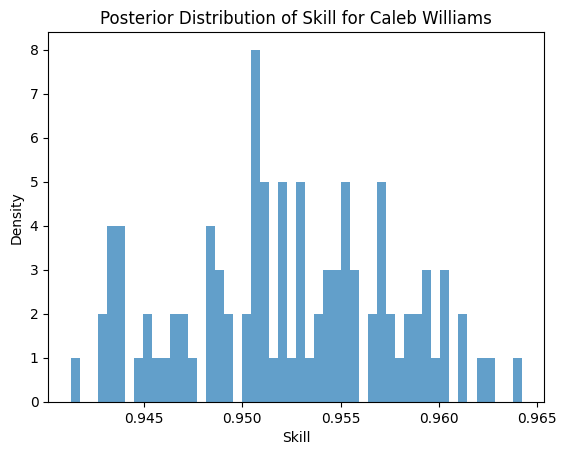

In [ ]:
# Let's plot the posterior of some player's skill
player_name = 'Caleb Williams'
skill_samples = posterior_samples[f'{player_name}_skill'].numpy()

plt.hist(skill_samples, bins=50, alpha=0.7)
plt.title(f'Posterior Distribution of Skill for {player_name}')
plt.xlabel('Skill')
plt.ylabel('Density')
plt.show()

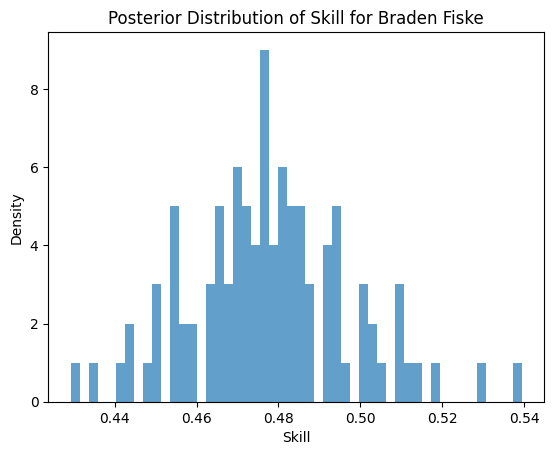

In [ ]:
# Let's plot the posterior of some player's skill
player_name = 'Braden Fiske'
skill_samples = posterior_samples[f'{player_name}_skill'].numpy()

plt.hist(skill_samples, bins=50, alpha=0.7)
plt.title(f'Posterior Distribution of Skill for {player_name}')
plt.xlabel('Skill')
plt.ylabel('Density')
plt.show()

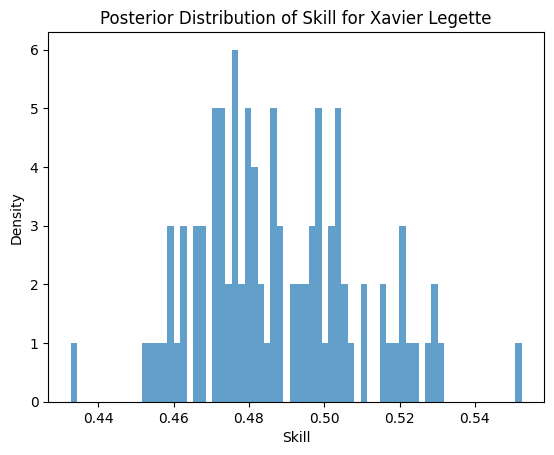

In [ ]:
# Let's plot the posterior of some player's skill
player_name = 'Xavier Legette'
skill_samples = posterior_samples[f'{player_name}_skill'].numpy()

plt.hist(skill_samples, bins=70, alpha=0.7)
plt.title(f'Posterior Distribution of Skill for {player_name}')
plt.xlabel('Skill')
plt.ylabel('Density')
plt.show()

Probability that a Braden Fiske has higher skill than Xavier Legette is: 0.320
Probability that a Braden Fiske has .05 higher skill than Xavier Legette is: 0.000
Probability that a Braden Fiske has .10 higher skill than Xavier Legette is: 0.000


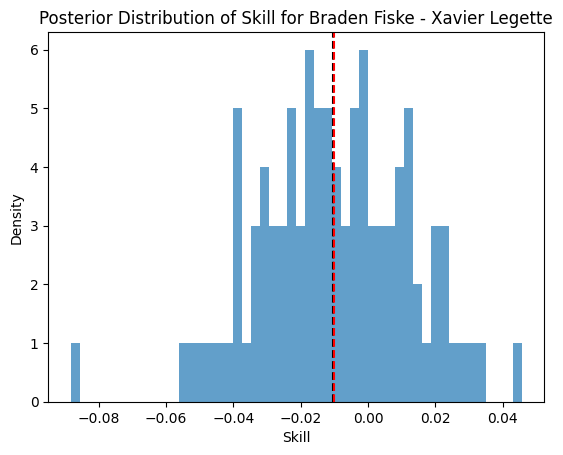

In [ ]:
# Let's plot the posterior of some player's skill
player_a = 'Braden Fiske'
player_b = 'Xavier Legette'
skill_a = posterior_samples[f'{player_a}_skill'].numpy()
skill_b = posterior_samples[f'{player_b}_skill'].numpy()
diff = skill_a-skill_b
med = np.median(diff)
avg = np.mean(diff)
probability_a_better_than_b = (diff > 0.0).mean()
probability_a_better_than_b_5 = (diff > 0.05).mean()
probability_a_better_than_b_10 = (diff > 0.10).mean()


print(f"Probability that a {player_a} has higher skill than {player_b} is: {probability_a_better_than_b:.3f}")
print(f"Probability that a {player_a} has .05 higher skill than {player_b} is: {probability_a_better_than_b_5:.3f}")
print(f"Probability that a {player_a} has .10 higher skill than {player_b} is: {probability_a_better_than_b_10:.3f}")
plt.hist(skill_a-skill_b, bins=50, alpha=0.7)
plt.axvline(med, color='black', linestyle='dashed', label=f'Median: {med:.2f}')
plt.axvline(avg, color='red', linestyle='dashed', label=f'Mean: {med:.2f}')
plt.title(f'Posterior Distribution of Skill for {player_a} - {player_b}')
plt.xlabel('Skill')
plt.ylabel('Density')
plt.show()

<ipython-input-134-eb91dfe004f0>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Skill', y='Player', data=df_skills, orient='h', palette="vlag")


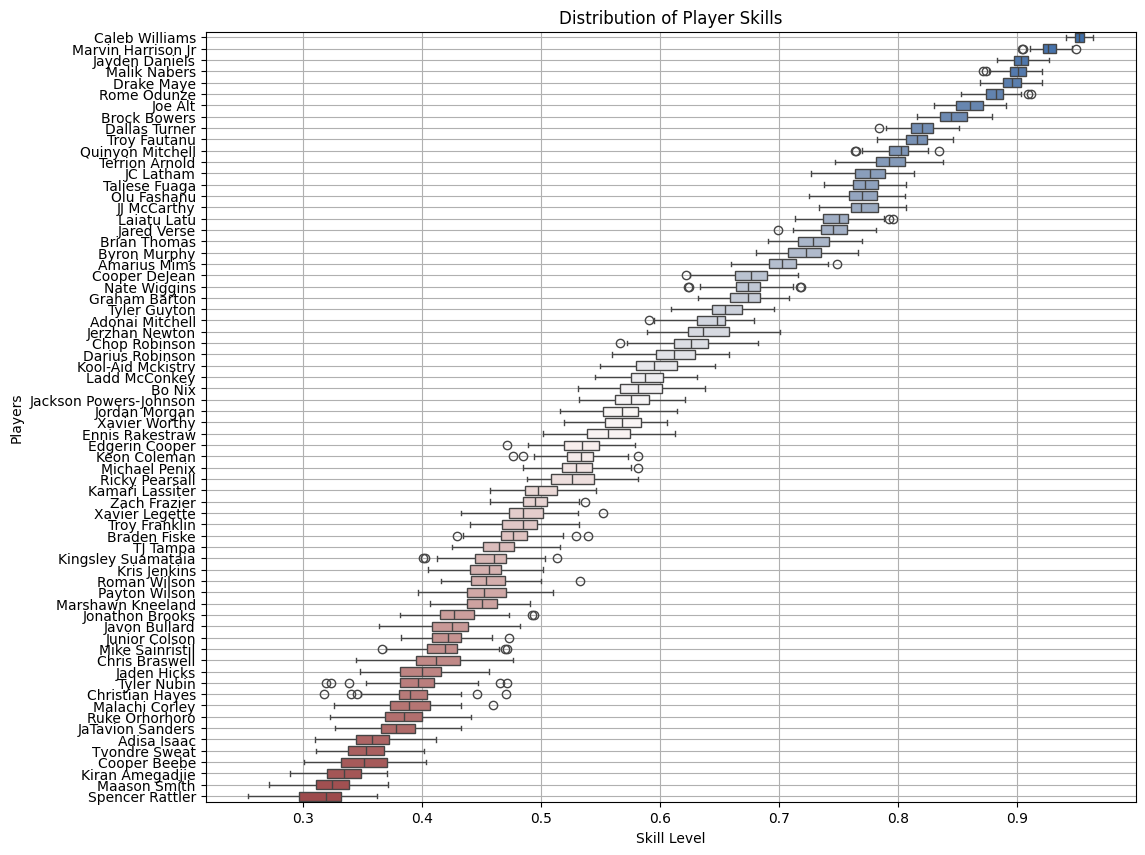

In [ ]:
# Extract skill data and calculate median for each player
players = [name for name in posterior_samples.keys() if '_skill' in name]
skills_data = {player: posterior_samples[player].numpy() for player in players}
#medians = {player: np.median(skills) for player, skills in skills_data.items()}

# Create DataFrame for plotting
df_skills = pd.DataFrame([(key.split('_skill')[0], skill) for key, skills in skills_data.items() for skill in skills], columns=['Player', 'Skill'])

# Add median skill for sorting
median_skills = df_skills.groupby('Player')['Skill'].median().reset_index()
median_skills.rename(columns={'Skill': 'Median Skill'}, inplace=True)
df_skills = df_skills.merge(median_skills, on='Player')
df_skills.sort_values('Median Skill', ascending=False, inplace=True)

# Plotting
plt.figure(figsize=(12, 10))
sns.boxplot(x='Skill', y='Player', data=df_skills, orient='h', palette="vlag")
plt.title('Distribution of Player Skills')
plt.xlabel('Skill Level')
plt.ylabel('Players')
plt.grid(True)
plt.show()


<ipython-input-146-c605b179e04b>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Skill', y='Player', data=df_skills, orient='h', palette="vlag")


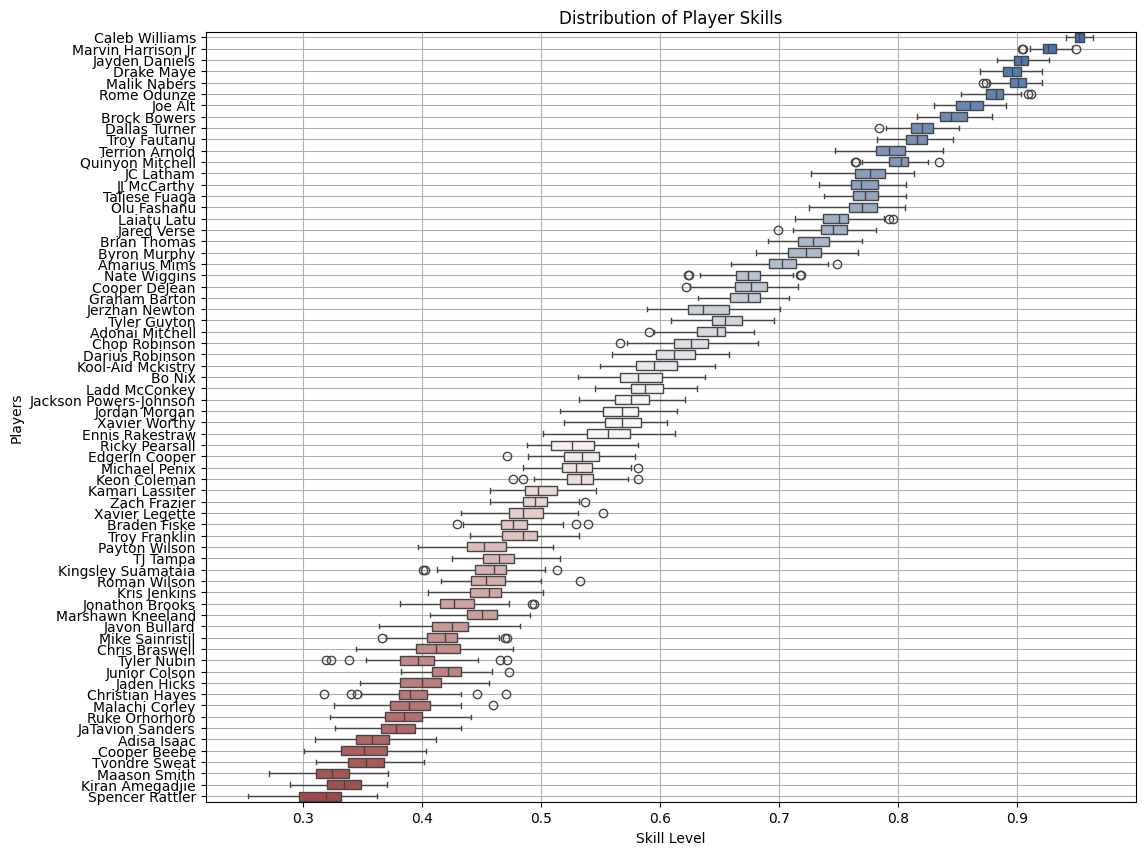

In [ ]:
# Extract skill data and calculate median for each player
players = [name for name in posterior_samples.keys() if '_skill' in name]
skills_data = {player: posterior_samples[player].numpy() for player in players}
#medians = {player: np.median(skills) for player, skills in skills_data.items()}

# Create DataFrame for plotting
df_skills = pd.DataFrame([(key.split('_skill')[0], skill) for key, skills in skills_data.items() for skill in skills], columns=['Player', 'Skill'])

# Add median skill for sorting
median_skills = df_skills.groupby('Player')['Skill'].quantile(.99).reset_index()
median_skills.rename(columns={'Skill': 'Median Skill'}, inplace=True)
df_skills = df_skills.merge(median_skills, on='Player')
df_skills.sort_values('Median Skill', ascending=False, inplace=True)

# Plotting
plt.figure(figsize=(12, 10))
sns.boxplot(x='Skill', y='Player', data=df_skills, orient='h', palette="vlag")
plt.title('Distribution of Player Skills')
plt.xlabel('Skill Level')
plt.ylabel('Players')
plt.grid(True)
plt.show()

In [ ]:
median_skills = df_skills.groupby('Player')['Skill'].median().reset_index()
median_skills.rename(columns={'Skill': 'Median Skill'}, inplace=True)
median_skills

,Player,Median Skill
0,Adisa Isaac,0.357821
1,Adonai Mitchell,0.648170
2,Amarius Mims,0.702994
3,Bo Nix,0.581368
4,Braden Fiske,0.476760
...,...,...
63,Tyler Guyton,0.654682
64,Tyler Nubin,0.396423
65,Xavier Legette,0.485015
66,Xavier Worthy,0.568213


In [ ]:
# Merge the original df_skills with sorted median skills to maintain order in plotting
df_skills = df_skills.merge(median_skills, on='Player')
df_skills

,Player,Skill,Median Skill
0,Adisa Isaac,0.357999,0.357821
1,Adisa Isaac,0.372760,0.357821
2,Adisa Isaac,0.351630,0.357821
3,Adisa Isaac,0.345853,0.357821
4,Adisa Isaac,0.320682,0.357821
...,...,...,...
6795,Zach Frazier,0.470731,0.494815
6796,Zach Frazier,0.528500,0.494815
6797,Zach Frazier,0.457519,0.494815
6798,Zach Frazier,0.525069,0.494815


In [ ]:
skill_a-skill_b

array([ 0.08295739,  0.00305873,  0.0835318 ,  0.07733482,  0.03881013,
        0.05492783,  0.03103518,  0.03050715,  0.05910641,  0.02586508,
        0.05113471,  0.02697188,  0.03928006,  0.04146469,  0.0140574 ,
        0.05667281,  0.07584661,  0.02861387,  0.04216725,  0.01757854,
        0.06450623,  0.03772068,  0.03582489,  0.03712255,  0.0580402 ,
        0.04291993,  0.0602231 ,  0.02328885,  0.07303137,  0.02301526,
        0.04177183,  0.05395156,  0.05112237,  0.05013096,  0.03439623,
        0.02868944,  0.05061305,  0.04666996,  0.0393033 ,  0.02420074,
        0.01228714,  0.08146584,  0.05221921,  0.03040683,  0.01657307,
        0.02772248,  0.05564874,  0.03629726,  0.06332475,  0.02200729,
        0.06828946,  0.04992503,  0.03164059,  0.02893203,  0.06148154,
        0.05031025,  0.09162343, -0.0068137 ,  0.07855165,  0.01820874,
        0.07005495,  0.04016989,  0.0411396 ,  0.02642119,  0.05408263,
        0.02449322,  0.05377084,  0.02252752,  0.06597245,  0.05

In [ ]:
small_data = data.head(10)

def model(data):
    players = data['Name'].unique()
    player_skills = {}
    for player in players:
        player_skills[player] = pyro.sample(
            f"{player}_skill",
            dist.Beta(2.0, 40.0)
        )

    for index, row in data.iterrows():
        pyro.sample(
            f"obs_{row['Name']}_{row['Analyst']}",
            dist.Beta(player_skills[row['Name']] * 99 + 1, (1 - player_skills[row['Name']]) * 99 + 1),
            obs=torch.tensor(row['Score'])
        )

# Assuming 'data' is your DataFrame loaded from CSV with the correct format
from pyro.infer.mcmc import HMC
from pyro.infer.autoguide.initialization import init_to_median

# Use a different kernel and initialization
# Correct usage of init_to_median
hmc_kernel = HMC(model, step_size=0.01, num_steps=5,
                 init_strategy=init_to_median())

mcmc = MCMC(hmc_kernel, num_samples=50, warmup_steps=10)
mcmc.run(small_data)

Sample: 100%|██████████| 60/60 [00:01, 59.13it/s, step size=5.90e-02, acc. prob=0.762]


In [ ]:
def model(data):
    alpha = pyro.sample("alpha", dist.Exponential(torch.tensor(2.0)))
    beta = pyro.sample("beta", dist.Exponential(torch.tensor(40.0)))
    with pyro.plate("data", len(data)):
        pyro.sample("obs", dist.Beta(alpha, beta), obs=data)

# Observations
data = torch.tensor([0.90, 0.99, 0.99, 0.99])

# Run MCMC to sample from the posterior
from pyro.infer import MCMC, NUTS
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=500, warmup_steps=200)
mcmc.run(data)

# Get posterior samples
posterior_samples = mcmc.get_samples()

Warmup:   0%|          | 0/700 [00:00, ?it/s]

ValueError: Model specification seems incorrect - cannot find valid initial params.

In [ ]:
data

tensor([0.9000, 0.9500, 0.8700, 0.9500])

Alpha Summary Statistics:
Mean: 0.74311525
Median: 0.62350774
Standard Deviation: 0.48935774

Beta Summary Statistics:
Mean: 0.09628912
Median: 0.085969776
Standard Deviation: 0.04679301


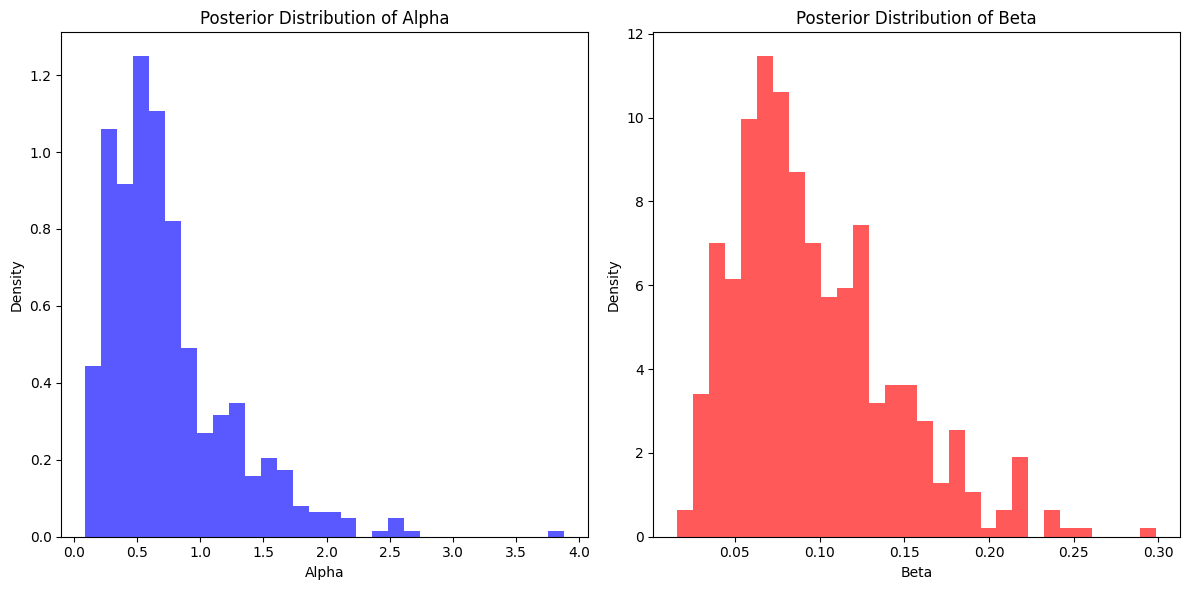

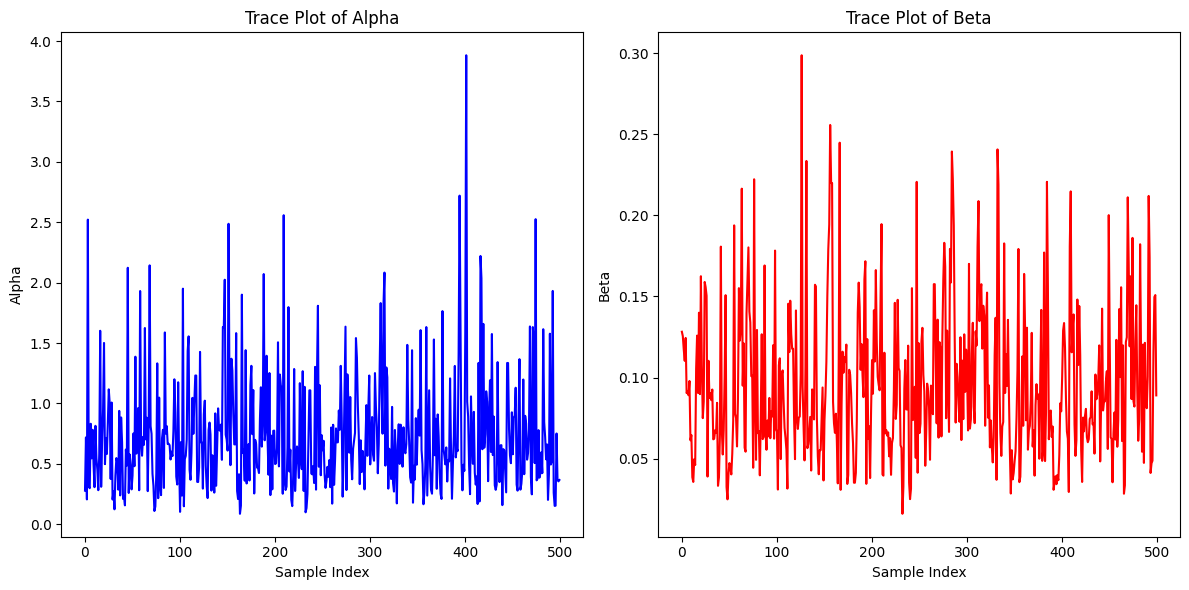

In [ ]:
# Summary statistics
alpha_samples = posterior_samples['alpha'].numpy()
beta_samples = posterior_samples['beta'].numpy()

print("Alpha Summary Statistics:")
print("Mean:", np.mean(alpha_samples))
print("Median:", np.median(alpha_samples))
print("Standard Deviation:", np.std(alpha_samples))

print("\nBeta Summary Statistics:")
print("Mean:", np.mean(beta_samples))
print("Median:", np.median(beta_samples))
print("Standard Deviation:", np.std(beta_samples))

# Histogram of the samples
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(alpha_samples, bins=30, density=True, alpha=0.65, color='blue')
plt.title('Posterior Distribution of Alpha')
plt.xlabel('Alpha')
plt.ylabel('Density')

plt.subplot(1, 2, 2)
plt.hist(beta_samples, bins=30, density=True, alpha=0.65, color='red')
plt.title('Posterior Distribution of Beta')
plt.xlabel('Beta')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

# Trace plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(alpha_samples, color='blue')
plt.title('Trace Plot of Alpha')
plt.xlabel('Sample Index')
plt.ylabel('Alpha')

plt.subplot(1, 2, 2)
plt.plot(beta_samples, color='red')
plt.title('Trace Plot of Beta')
plt.xlabel('Sample Index')
plt.ylabel('Beta')

plt.tight_layout()
plt.show()


In [ ]:
2.18/(2.18+.56)

0.7956204379562044

Warmup:   0%|          | 0/60 [05:27, ?it/s]


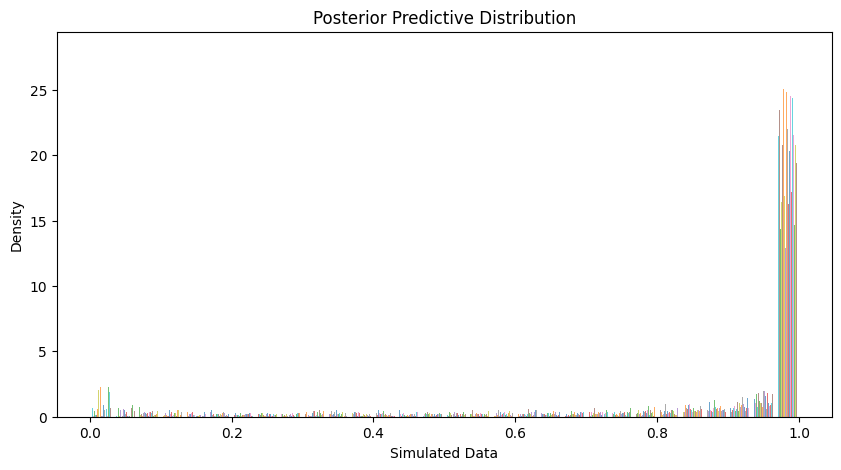

In [ ]:
# Using posterior samples to generate new data
alpha_tensor = torch.tensor(posterior_samples['alpha'].numpy())
beta_tensor = torch.tensor(posterior_samples['beta'].numpy())
predicted_data = dist.Beta(alpha_tensor, beta_tensor).sample((1000,))

plt.figure(figsize=(10, 5))
plt.hist(predicted_data.numpy(), bins=30, density=True, alpha=0.65) #color='green')
plt.title('Posterior Predictive Distribution')
plt.xlabel('Simulated Data')
plt.ylabel('Density')
plt.show()


In [ ]:
probability_greater_than_0_9 = (predicted_data > 0.90).float().mean()
print(f"Probability that a new observation is > 0.9: {probability_greater_than_0_9:.3f}")


Probability that a new observation is > 0.9: 0.745
